# IMDb Sentiment Analysis - Classical Models

In [1]:
import re
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import shap

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the IMDb dataset
df = pd.read_csv("../data/raw/IMDB Dataset.csv")

In [3]:
# Text cleaning function to remove HTML and non-alphabetic characters
def clean_text(text):
    text = re.sub(
        r"<br\s*/?>", " ", text
    )  # Replace HTML line breaks with space
    text = re.sub(r"<.*?>", "", text)  # Remove remaining HTML tags
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    return text


# Remove duplicate reviews to avoid bias
df = df.drop_duplicates()

# Apply cleaning
df["review"] = df["review"].apply(clean_text)

# Encode sentiment labels
df["label"] = df["sentiment"].map({"positive": True, "negative": False})

## TF-IDF Vectorization

TF-IDF stands for **Term Frequency-Inverse Document Frequency**. It's a numerical statistic that reflects how important a word is to a document in a collection.

- **Term Frequency (TF):** how often a term appears in a document.
- **Inverse Document Frequency (IDF):** how unique or rare the term is across all documents.
- The resulting score increases with term frequency but is offset by the number of documents that contain the word, helping to reduce the impact of frequently occurring but less meaningful words.

In this project:
- We limit to `max_features=10000` to reduce dimensionality.
- `stop_words='english'` removes common English stopwords (like "the", "is", etc.).
- Each review becomes a vector of 10,000 dimensions representing TF-IDF scores.


In [4]:
vectorizer_filename = "../models/tfidf_vectorizer.pkl"

try:
    vectorizer = joblib.load(vectorizer_filename)
    X_tfidf = vectorizer.transform(df["review"])
    print(f"Loaded TF-IDF vectorizer from {vectorizer_filename}")
except FileNotFoundError:
    # Feature extraction using TF-IDF (term frequency-inverse document frequency)
    vectorizer = TfidfVectorizer(max_features=10000, stop_words="english")
    X_tfidf = vectorizer.fit_transform(df["review"])

    # Save vectorizer
    joblib.dump(vectorizer, vectorizer_filename)
    print(f"Built and saved TF-IDF vectorizer to {vectorizer_filename}")

y = df["label"]

Loaded TF-IDF vectorizer from ../models/tfidf_vectorizer.pkl


The plot below shows the TF-IDF scores of a sample review, highlighting the top scoring terms (most relevant in that context).

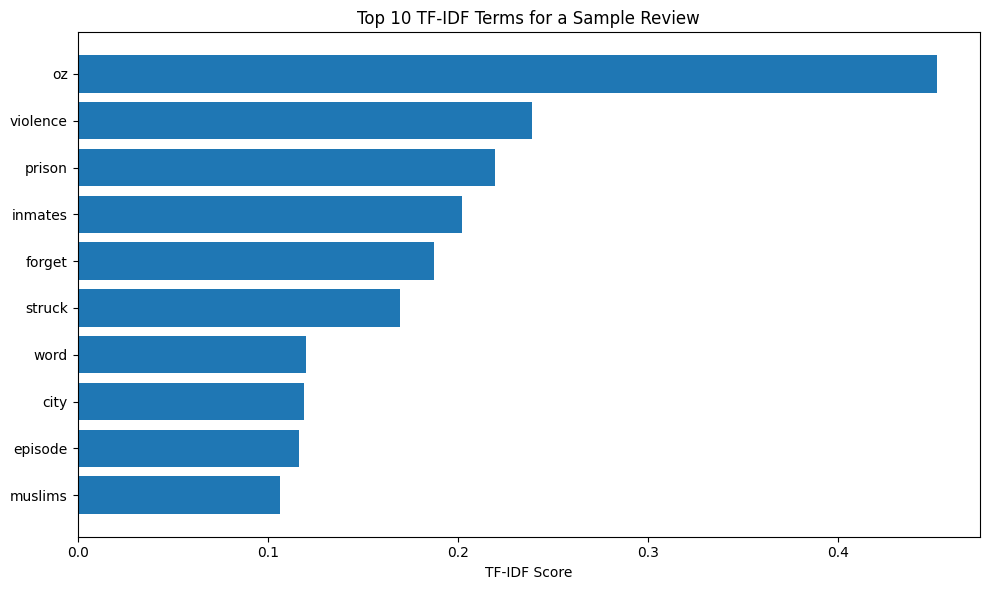

In [5]:
# Example TF-IDF feature scores for a sample review
sample_index = 0
sample_vector = X_tfidf[sample_index].toarray().flatten()
sample_terms = np.array(vectorizer.get_feature_names_out())
nonzero_idx = sample_vector.nonzero()[0]

sorted_idx = nonzero_idx[np.argsort(sample_vector[nonzero_idx])][
    -10:
]  # Top 10

plt.figure(figsize=(10, 6))
plt.title("Top 10 TF-IDF Terms for a Sample Review")
plt.barh(range(len(sorted_idx)), sample_vector[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), sample_terms[sorted_idx])
plt.xlabel("TF-IDF Score")
plt.tight_layout()
plt.show()

* The TF-IDF vectorizer has successfully captured **content-specific and thematically relevant** tokens.
* Words like `"oz"`, `"prison"`, `"violence"` are **highly informative**, likely to be important for classification (positive/negative sentiment).
* **Personal nouns and dramatic events** dominate the representation — this may indicate a **serious, intense review** (either positive for realism or negative due to discomfort).
* **Highest weighted term**: `"oz"` → This likely refers to the **TV series *Oz***, set in a prison — indicating the review focuses heavily on that show.
* Other high-scoring terms: `"violence"`, `"prison"`, `"inmates"`, `"struck"` → These are **contextual and emotionally loaded words** associated with crime, intensity, or traumatic experience.
* These high-weighted words help classical models (e.g. Logistic Regression) decide the sentiment label.
* If this review is misclassified, checking these top TF-IDF features might explain why.
* Comparing them with SHAP values would show whether these tokens pushed the sentiment prediction toward positive or negative.

## Cross-Validation Evaluation
Instead of a single train/test split, we use Stratified K-Fold Cross-Validation.
This method provides a more reliable estimate of model performance across different data splits, especially useful with large balanced datasets like IMDb.

* **Accuracy** gives an overall view but can be misleading in imbalanced datasets.
* **Macro F1-score** balances precision and recall across both classes, and avoids being overly optimistic in class-imbalanced or skewed predictions. Since we care about both false positives and false negatives in sentiment classification, this is a safer metric.
* **ROC AUC** measures ability to rank positive over negative, important when thresholds vary.

In [6]:
def evaluate_model_cv(model, X, y, model_name):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accs, f1s, rocs = [], [], []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = (
            model.predict_proba(X_test)[:, 1]
            if hasattr(model, "predict_proba")
            else model.decision_function(X_test)
        )

        accs.append(accuracy_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred, average="macro"))
        rocs.append(roc_auc_score(y_test, y_prob))

    # Save model after training on full set
    model.fit(X, y)
    joblib.dump(model, f"../models/{model_name.lower()}.pkl")

    return {
        "Model": model_name,
        "Accuracy": np.mean(accs),
        "F1 Score": np.mean(f1s),
        "ROC AUC": np.mean(rocs),
        "model_obj": model,
    }

In [7]:
# Initialize and evaluate models
models = [
    ("LogisticRegression", LogisticRegression(max_iter=1000)),
    ("MultinomialNB", MultinomialNB()),
    ("LinearSVC", LinearSVC()),
]

results = [
    evaluate_model_cv(model, X_tfidf, y.values, name) for name, model in models
]

                Model  Accuracy  F1 Score   ROC AUC
0  LogisticRegression  0.890222  0.890191  0.956986
1       MultinomialNB  0.856137  0.856133  0.931443
2           LinearSVC  0.879896  0.879883  0.951241


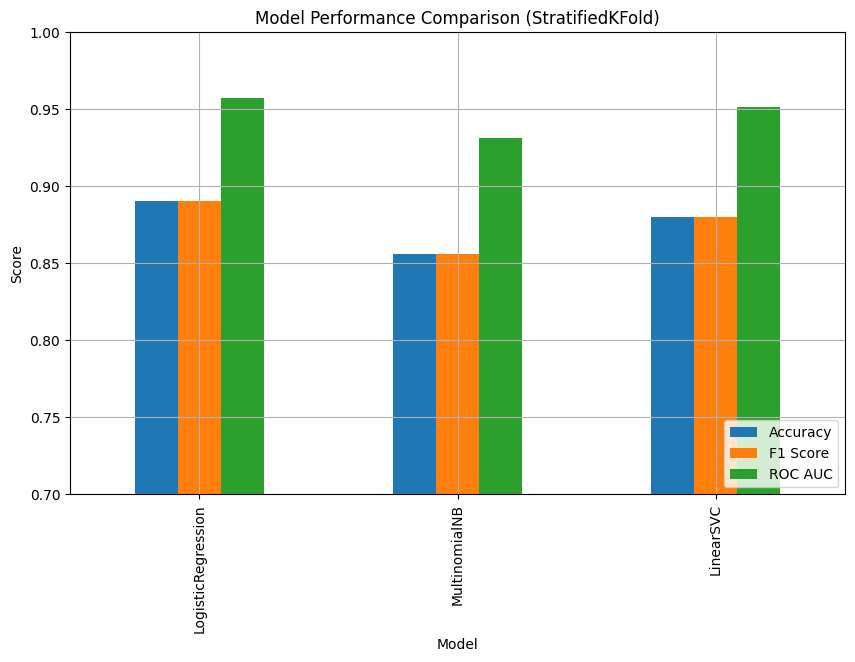

In [8]:
# Convert results to DataFrame and plot
eval_df = pd.DataFrame(
    [{k: v for k, v in r.items() if k != "model_obj"} for r in results]
)
print(eval_df)

# Plot comparison
eval_df.set_index("Model")[["Accuracy", "F1 Score", "ROC AUC"]].plot(
    kind="bar", figsize=(10, 6)
)
plt.title("Model Performance Comparison (StratifiedKFold)")
plt.ylabel("Score")
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.legend(loc="lower right")
plt.show()

eval_df.to_csv("../models/eval_classical.csv")

**Logistic Regression** is the top performer:

* Achieves the **highest ROC AUC (\~0.96)**, indicating excellent ranking ability.
* Solid performance across all metrics (balanced precision and recall).

**LinearSVC** is a close second:

* Slightly lower scores than Logistic Regression.
* Still robust and often used when interpretability is less critical.

**Multinomial Naive Bayes**:

* Surprisingly competitive given its simplicity.

**Conclusion**:

* **Use Logistic Regression** as the primary classical baseline — simple, fast, and effective.
* **Consider LinearSVC** if we need margin-based classification.


## Model Interpretation

### Interpreting SHAP Summary Plots

SHAP (SHapley Additive exPlanations) allows us to understand the model's decisions by showing feature importance at global and local levels.

The SHAP summary plot shows how each feature (TF-IDF word) contributes to the prediction.
- **X-axis**: SHAP value (impact on model output). Positive = leaning toward class 1 (positive sentiment).
- **Color**: Red = higher TF-IDF value for that feature; Blue = lower TF-IDF value.
- **Position**: Features at the top are most influential.

For example, if "excellent" appears near the top-right in red, it means when this word has a high TF-IDF value, it strongly contributes to positive sentiment.  
Conversely, if "worst" is red and far left, it has a strong negative influence.


SHAP Summary for LogisticRegression:


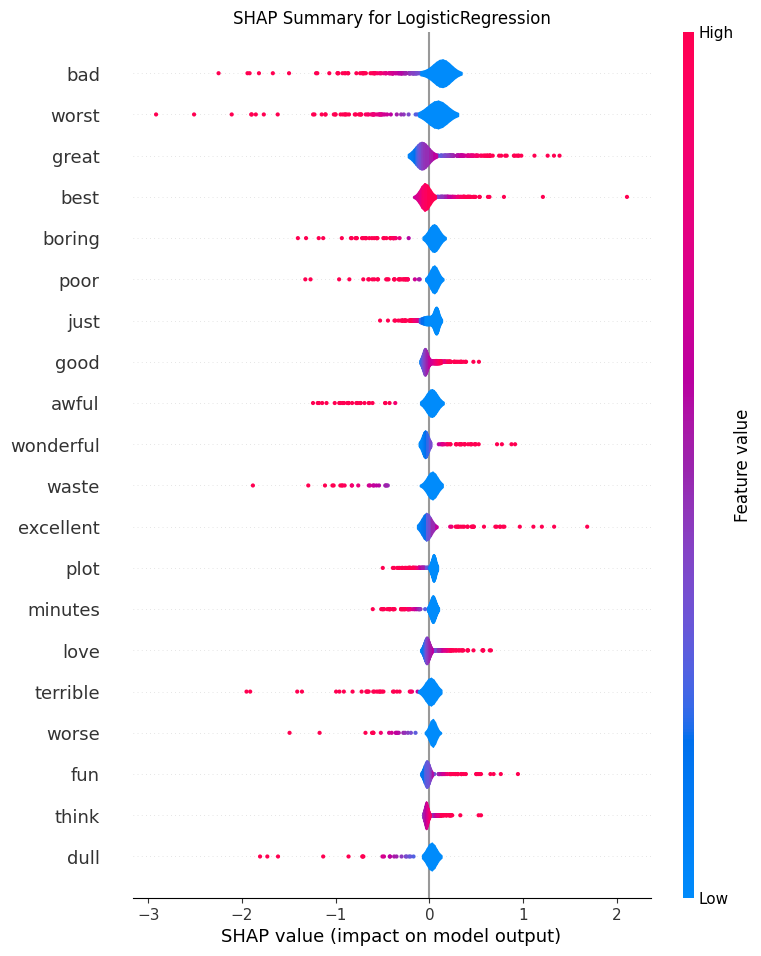


SHAP Summary for LinearSVC:


/usr/local/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


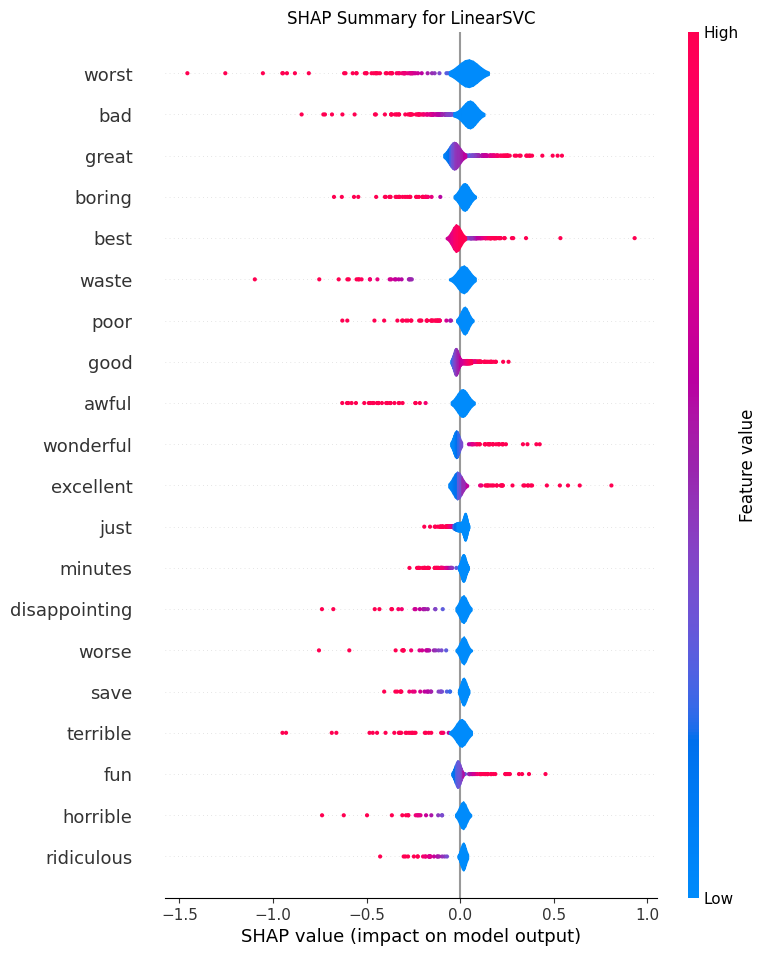

In [10]:
# Only compatible with linear and logreg models; sample subset for SHAP due to memory
sample_X = X_tfidf[:500]
sample_y = y[:500].values

for res in results:
    model_name = res["Model"]
    model = res["model_obj"]

    if model_name in ["MultinomialNB"]:
        continue

    # if hasattr(model, 'coef_') or hasattr(model, 'feature_importances_'):
    print(f"\nSHAP Summary for {model_name}:")

    if hasattr(model, "coef_") or hasattr(model, "feature_importances_"):
        try:
            # Convert to dense
            sample_input = sample_X.toarray()

            if model_name == "LinearSVC":
                explainer = shap.LinearExplainer(
                    model, sample_input, feature_perturbation="interventional"
                )
                shap_values = explainer.shap_values(sample_input)
            else:
                explainer = shap.Explainer(model, sample_input)
                shap_values = explainer(sample_input)

            shap.summary_plot(
                shap_values,
                sample_input,
                feature_names=vectorizer.get_feature_names_out(),
                plot_type="violin",
                show=False,
            )
            plt.title(f"SHAP Summary for {model_name}")
            plt.show()
        except Exception as e:
            print(f"SHAP failed for {model_name}: {e}")

Both models identify similar **key sentiment-indicative words**, with **consistent polarity**:

| Positive Sentiment Words                                         | Negative Sentiment Words                                                     |
| ---------------------------------------------------------------- | ---------------------------------------------------------------------------- |
| `great`, `best`, `excellent`, `wonderful`, `good`, `love`, `fun` | `bad`, `worst`, `boring`, `poor`, `waste`, `awful`, `terrible`, `ridiculous` |

These are **intuitively aligned** with the task of sentiment analysis.

**Logistic Regression**

* **Higher SHAP value spread**: Words like `best`, `great`, and `bad` show **larger impact magnitudes** (up to ±3), meaning the model strongly reacts to these keywords.
* Example:

  * `bad`: SHAP values strongly negative.
  * `great`/`best`: strong positive SHAP values.
* **Model appears more sensitive to extremes**, possibly due to the probabilistic nature of logistic regression.

**Linear SVC**

* **More compact SHAP value range**: SHAP impacts generally fall within ±1.5.
* The overall word impact is **flatter**, possibly because SVC finds a separating hyperplane rather than probabilities.
* Introduces some unique words not as prominent in Logistic Regression, such as:

  * `disappointing`, `save`, `horrible` → indicates **slightly different feature sensitivity**.


**Conclusion**

* Both models clearly **understand sentiment-laden vocabulary**, identifying meaningful words that contribute to classifying reviews as positive or negative.
* **Logistic Regression** is more expressive with extreme values, which may make it **better for interpretability**.
* **LinearSVC** exhibits **more stability and regularization**, potentially making it more **robust** on borderline or ambiguous reviews.

If **interpretability and confidence in strong indicators** matter, Logistic Regression edges ahead. If we seek a **more stable, margin-based classifier**, LinearSVC is a solid choice.

### Interpreting Naive Bayes Explanation

In `MultinomialNB`, the model learns log-probabilities of each word given the class (i.e., `P(word|class)`).
These log-probabilities are available via `.feature_log_prob_`.

- A **higher log probability** means the word is more representative of that class.
- We rank these per class and visualize the most representative words.

For example, words like "amazing" or "loved" may appear in the top words for the positive class,
while "boring" or "worst" might show up for the negative class.

This gives an interpretable insight into what the Naive Bayes model learned as most important vocabulary.

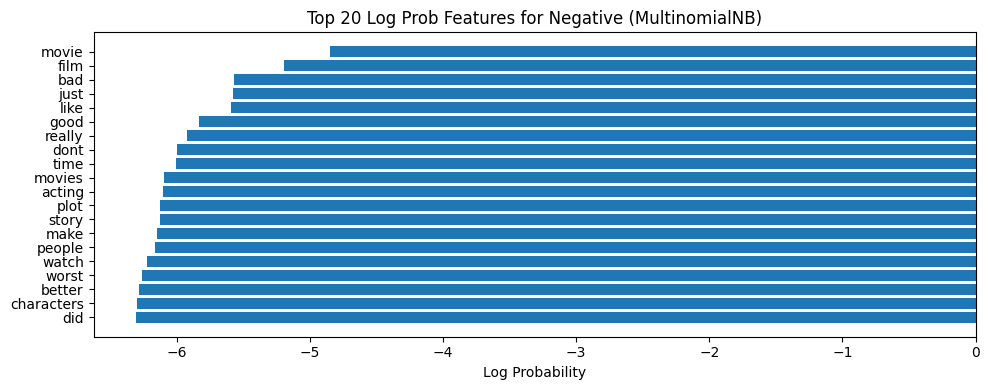

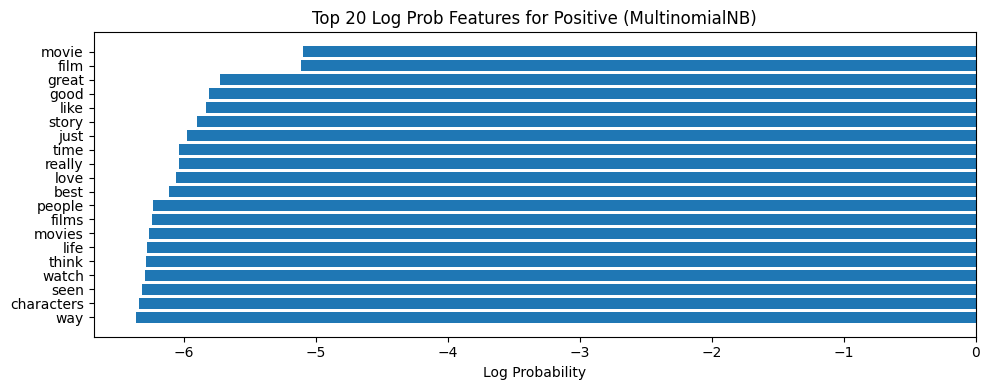

In [12]:
for res in results:
    model_name = res["Model"]
    model = res["model_obj"]

    if model_name == "MultinomialNB":
        try:
            class_log_probs = model.feature_log_prob_
            top_n = 20
            feature_names = np.array(vectorizer.get_feature_names_out())
            for i, class_label in enumerate(["Negative", "Positive"]):
                top_features = np.argsort(class_log_probs[i])[-top_n:]
                plt.figure(figsize=(10, 4))
                plt.barh(
                    range(top_n),
                    class_log_probs[i][top_features],
                    align="center",
                )
                plt.yticks(range(top_n), feature_names[top_features])
                plt.title(
                    f"Top {top_n} Log Prob Features for {class_label} (MultinomialNB)"
                )
                plt.xlabel("Log Probability")
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"Failed to explain MultinomialNB: {e}")

        break

The two bar charts show the **Top 20 log-probability features** for **negative** and **positive**. These features are the words most indicative of each sentiment class, ranked by their log probability under the class-conditional word distributions.

**Insight from Negative Class (Top Plot)**

* **Most indicative words:**
  `bad`, `worst`, `boring`, `plot`, `characters`, `watch`, `story`, `dont`, `time`, `really`

* **Neutral/ambiguous high-frequency words:**
  Words like `movie`, `film`, `just`, `like`, and `good` also appear, despite not being strongly negative. These are **commonly used across both sentiments**, but still have slightly higher probability in negative reviews.

* **Notable sentiment words:**

  * `bad`, `worst`, `boring`, `waste`, `poor`—clearly **negative indicators**

* **Insight:** Naive Bayes captures both:

  * **Sentiment-heavy words** (e.g., `bad`, `worst`)
  * **Contextual filler words** (e.g., `just`, `like`, `movie`) due to their overall frequency in negative texts.

**Insight from Positive Class (Bottom Plot)**

* **Most indicative words:**
  `great`, `best`, `love`, `excellent`, `wonderful`, `like`, `films`, `life`, `think`, `seen`

* **Neutral frequent words again present:**
  `movie`, `film`, `just`, `time`, `people`, `characters` — indicating frequent usage across sentiments.

* **Strongly positive sentiment words:**

  * `great`, `love`, `best`, `wonderful`, `excellent`, `life`—these clearly help the model lean toward the positive class.

* **Insight:** Words that express **emotional intensity and admiration** are dominant in positive reviews, and Naive Bayes picks up on that effectively.

**Common Words in Both Plots**

Words such as `movie`, `film`, `like`, `just`, `time`, `really`, `people`, `watch`, `characters`, and `story` appear in **both positive and negative** plots. This shows they are:

* **Not sentiment-specific**, but appear frequently in both classes.
* Naive Bayes still assigns them class-conditional probabilities, but their **discriminative power is limited**.

**Conclusion**

Multinomial Naive Bayes offers a **clear and interpretable** mapping between words and sentiment class. While it does a solid job identifying key sentiment words, its **bag-of-words assumption** means it may struggle with nuanced or context-dependent phrases. Nonetheless, it gives valuable insight into **which words drive predictions** and is a useful baseline in sentiment classification tasks.
